# Callbacks and Events

Docs:
- https://diffeq.sciml.ai/stable/features/callback_functions/#Using-Callbacks
- https://tutorials.sciml.ai/html/introduction/04-callbacks_and_events.html

## Types

- `ContinuousCallback`: applied when a given *continuous condition* function hits zero. SciML solvers are able to interpolate the integration step to meet the condition.
- `DiscreteCallback`: applied when its condition function is true.

- `CallbackSet(cb1, cb2, ...)`: Multiple callbacks can be chained together to form a `CallbackSet`.
- `VectorContinuousCallback`: an array of `ContinuousCallback`s.

## How to

After you define a callback, send it to the `solve()` function:

```julia
sol = solve(prob, alg, callback=cb)
```

## DiscreteCallback : Interventions at Preset Times

The drug concentration in the blood follows exponential decay.

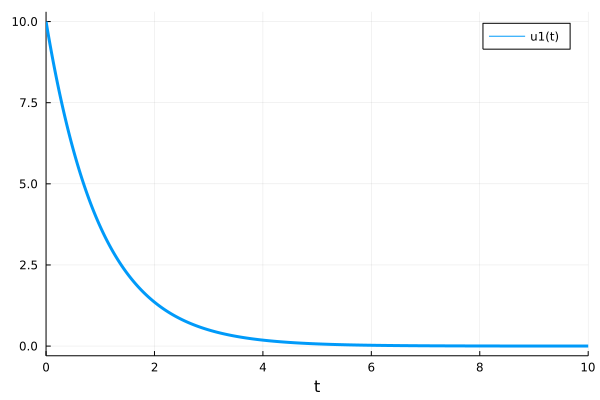

In [1]:
using DifferentialEquations
using Plots
Plots.gr(lw=3)

function dosing!(du, u, p, t)
    du[1] = -u[1]
end

u0 = [10.0]

prob = ODEProblem(dosing!, u0, (0.0,10.0))
sol = solve(prob, Tsit5())

plot(sol)

Add a dose of 10 at t = 4. You may need to force the solver to stop at `t==4` (hence the `tstops=[4.0]`) to apply the callback.

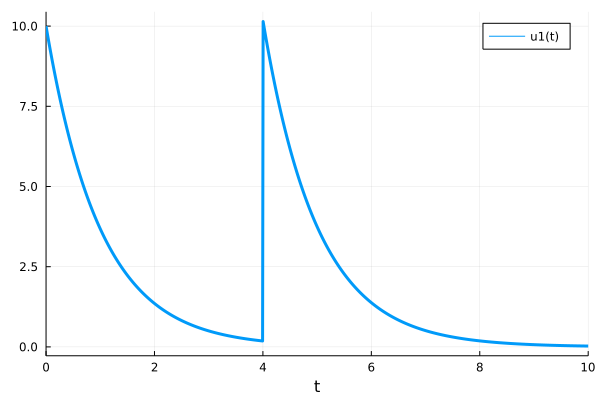

In [2]:
condition(u, t, integrator) = t==4
affect!(integrator) = integrator.u[1] += 10
cb = DiscreteCallback(condition, affect!)

sol = solve(prob, Tsit5(), callback=cb, tstops=[4.0])
plot(sol)

Applying multiple doses.

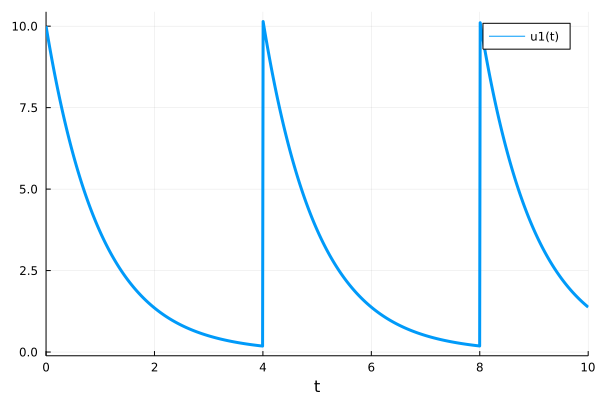

In [3]:
dosetimes = [4.0, 8.0]
condition(u,t,integrator) = t ∈ dosetimes
affect!(integrator) = integrator.u[1] += 10
cb = DiscreteCallback(condition,affect!)

sol = solve(prob, Tsit5(), callback=cb, tstops=dosetimes)
plot(sol)

Conditional dosing. Note that a dose was not given at t=6 because the conceentration is not more than 1.

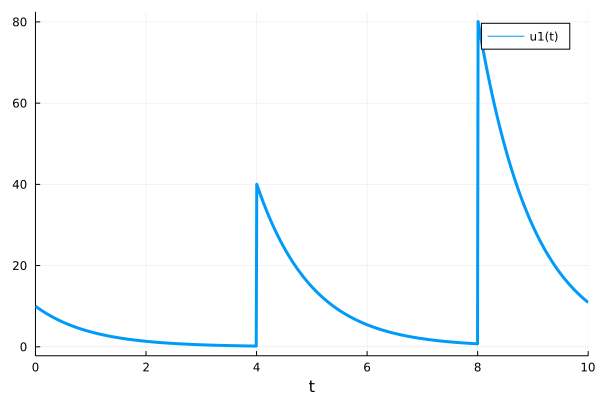

In [4]:
dosetimes = [4.0, 6.0, 8.0]
condition(u,t,integrator) = t ∈ dosetimes && (u[1] < 1.0)
affect!(integrator) = integrator.u[1] += 10integrator.t
cb = DiscreteCallback(condition, affect!)

sol = solve(prob, Tsit5(), callback=cb, tstops=dosetimes)
plot(sol)

### PresetTimeCallback

`PresetTimeCallback(tstops, affect!)` takes an array of times and an `affect!` function to apply. The solver will stop at `tstops` to ensure callbacks are applied.

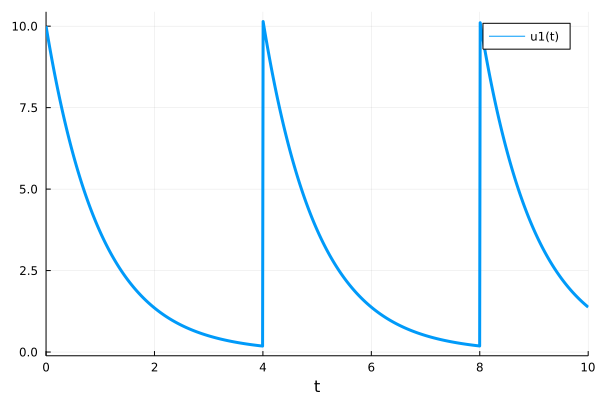

In [5]:
dosetimes = [4.0, 8.0]
affect!(integrator) = integrator.u[1] += 10
cb = PresetTimeCallback(dosetimes, affect!)
sol = solve(prob, Tsit5(), callback=cb)
plot(sol)

### Periodic callback

`PeriodicCallback` is a special case of `DiscreteCallback`, used when a function should be called periodically in terms of integration time (as opposed to wall time).

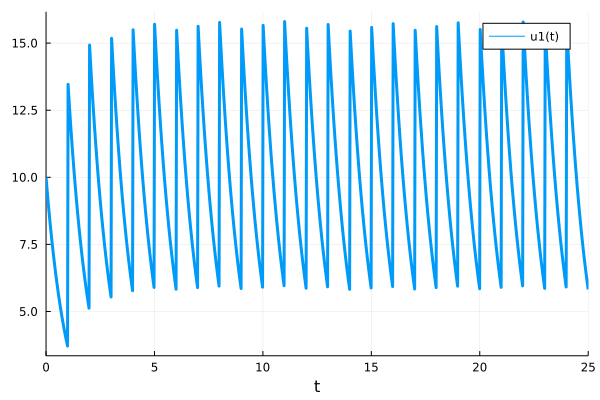

In [6]:
prob = ODEProblem(dosing!, u0, (0.0, 25.0))

affect!(integrator) = integrator.u[1] += 10
cb = PeriodicCallback(affect!, 1.0)

sol = solve(prob, Tsit5(), callback=cb)
plot(sol)

## ContinuousCallback: Bouncing Ball

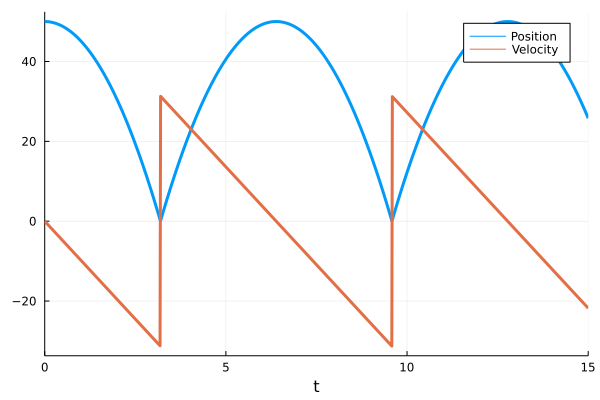

In [7]:
using DifferentialEquations
using Plots

function ball!(du, u, p, t)
    du[1] = u[2]
    du[2] = -p
end

# When the ball touches the ground
function condition(u, t, integrator) # Event when event_f(u,t) == 0
    u[1]
end

function affect!(integrator)
    integrator.u[2] = -integrator.u[2]
end

cb = ContinuousCallback(condition, affect!)

u0 = [50.0, 0.0]
tspan = (0.0, 15.0)
p = 9.8

prob = ODEProblem(ball!, u0, tspan, p)
sol = solve(prob, Tsit5(), callback=cb)
plot(sol, label=["Position" "Velocity"])

The solution is stable for repeated callbacks.

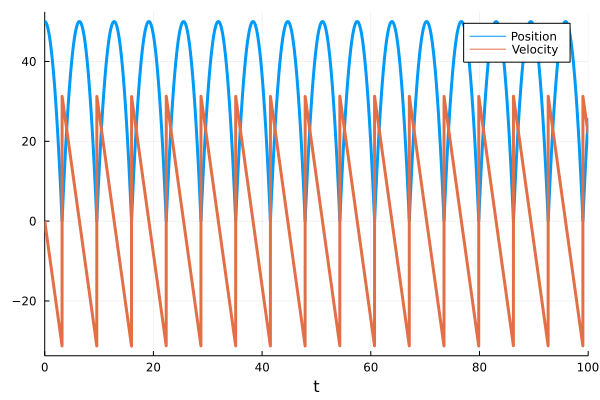

In [8]:
tspan = (0.0, 100.0)
prob = ODEProblem(ball!, u0, tspan, p)
sol = solve(prob, Tsit5(), callback=cb)
plot(sol, plotdensity=10000, label=["Position" "Velocity"])

## VectorContinuousCallback

Simulating bouncing ball with multiple walls.

In [9]:
function ball_2d!(du, u, p, t)
    du[1] = u[2]  # x_pos
    du[2] = -p    # x_vel  
    du[3] = u[4]  # y_pos
    du[4] = 0.0   # y_vel
end

# Vector condition
function condition(out, u, t, integrator) # Event when event_f(u,t) == 0
    out[1] = u[1]
    out[2] = (u[3] - 10.0)u[3]
end

# Vector affect!
function affect!(integrator, idx)
    if idx == 1
      integrator.u[2] = -0.9integrator.u[2]
    elseif idx == 2
      integrator.u[4] = -0.9integrator.u[4]
    end
end


cb = VectorContinuousCallback(condition, affect!, 2)

VectorContinuousCallback{typeof(condition), typeof(affect!), typeof(affect!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}(condition, affect!, affect!, 2, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, nothing, SciMLBase.LeftRootFind, 10, Bool[1, 1], 1, 2.220446049250313e-15, 0, 1//100)

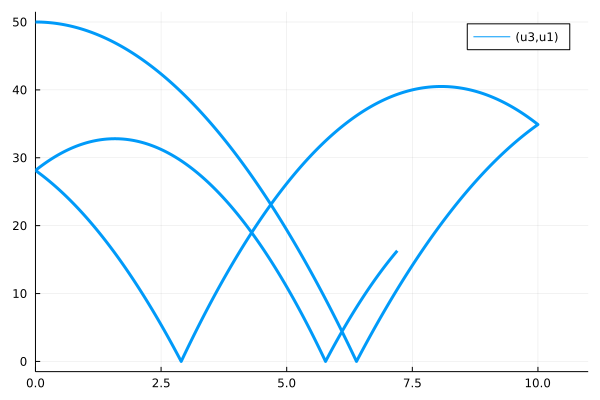

In [10]:
u0 = [50.0, 0.0, 0.0, 2.0]
tspan = (0.0, 15.0)
p = 9.8
prob = ODEProblem(ball_2d!, u0, tspan, p)
sol = solve(prob, Tsit5(), callback=cb, dt=1e-3, adaptive=false)
plot(sol, vars=(3, 1))

## Other Callbacks

https://diffeq.sciml.ai/stable/features/callback_library/

- `ManifoldProjection(g)`: keep `g(u) = 0`. For energy conservation.
- `AutoAbstol()`: automatically adapt the absolute tolerance like [the functionality in MATLAB](https://www.mathworks.com/help/simulink/gui/absolute-tolerance.html).
- `PositiveDomain()`: enforce non-negative solution. **The system should be defined also outside the positive domain**. There is also a more general version `GeneralDomain()`.
- `StepsizeLimiter((u,p,t) -> maxtimestep)`: restrict maximual allowed time step.
- `FunctionCallingCallback((u, t, int) -> func_content; funcat=[t1, t2, ...])`: call a function at the time points (t1, t2, ...) of interest.
- `SavingCallback((u, t, int) -> data_to_be_saved, dataprototype)`: call a function and saves the result.
- `IterativeCallback(time_choice(int) -> t2, user_affect!)`: apply an effect at the time of the next callback.
- `TerminateSteadyState()`: run until the solution reaches a steady state.